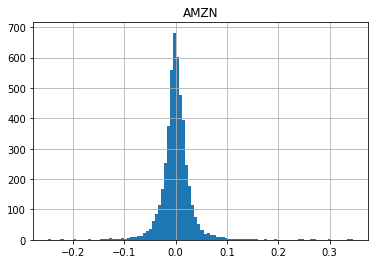

In [8]:
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

stocks = ['AMZN']

start_date='01/01/2001'
end_date='01/01/2020'

data = web.DataReader(stocks, data_source='yahoo', start=start_date, end=end_date)['Adj Close']

daily_returns = (data/data.shift(1))-1

daily_returns.hist(bins=100)
plt.show()


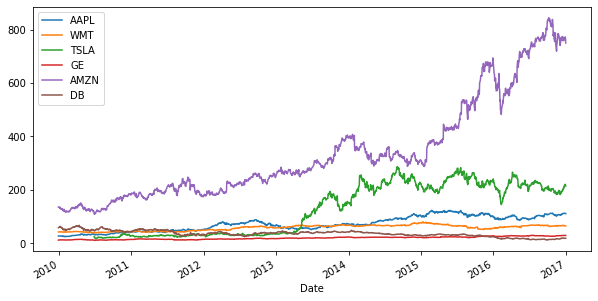

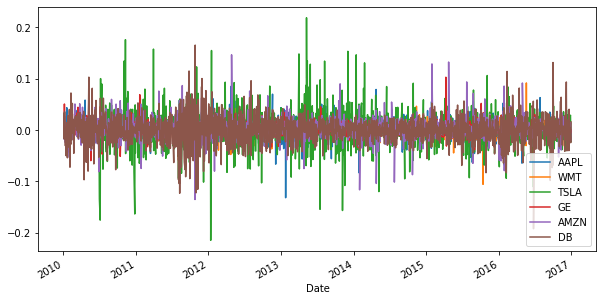

AAPL    0.206055
WMT     0.062387
TSLA    0.336881
GE      0.138246
AMZN    0.245734
DB     -0.170075
dtype: float64
          AAPL       WMT      TSLA        GE      AMZN        DB
AAPL  0.068786  0.009883  0.029641  0.021892  0.027784  0.036345
WMT   0.009883  0.026715  0.010949  0.013052  0.010737  0.020209
TSLA  0.029641  0.010949  0.274985  0.027283  0.047326  0.052331
GE    0.021892  0.013052  0.027283  0.047408  0.025799  0.054865
AMZN  0.027784  0.010737  0.047326  0.025799  0.104041  0.045003
DB    0.036345  0.020209  0.052331  0.054865  0.045003  0.175788
Expected portfolio return: 0.13435762422855427
Expected variance: 0.25414814107122286


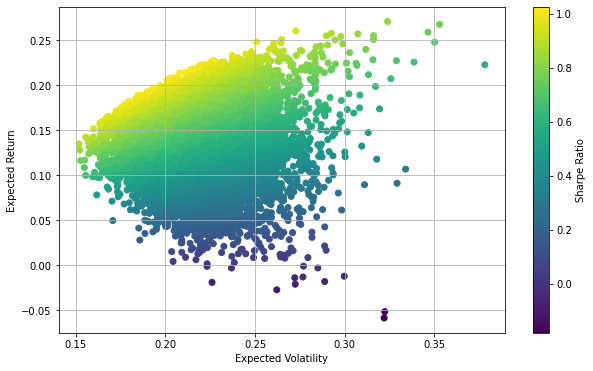

Optimal weights: [0.36  0.085 0.138 0.163 0.254 0.   ]
Expected return, volatility and Sharpe ratio: [0.21092283 0.20317567 1.03813036]


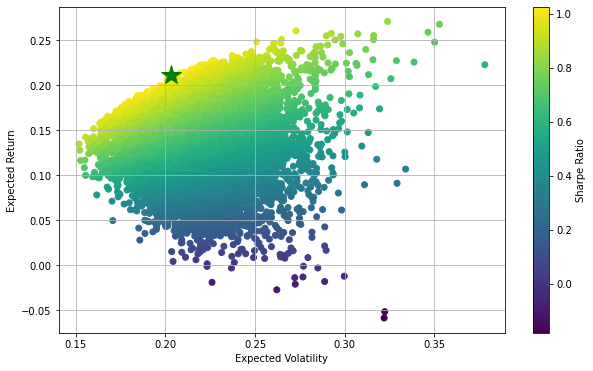

In [9]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as optimization

#these are the stocks we can choose in our portfolio
stocks = ['AAPL','WMT','TSLA','GE','AMZN','DB']

#we use historical data to approximate mean and variance: MPT depends on historical data !!!
start_date='01/01/2010'
end_date ='01/01/2017'

#downloading the data from Yahoo! Finance
def download_data(stocks):
	data = web.DataReader(stocks,data_source='yahoo',start=start_date,end=end_date)['Adj Close']	
	data.columns = stocks
	return data
	
def show_data(data):
	data.plot(figsize=(10,5))
	plt.show()

#we usually use natural logarithm for normalization purposes
def calculate_returns(data):
	returns = np.log(data/data.shift(1))
	return returns;
	
def plot_daily_returns(returns):
	returns.plot(figsize=(10,5))
	plt.show()

#print out mean and covariance of stocks within [start_date, end_date]. There are 252 trading days within a year
def show_statistics(returns):
	print(returns.mean()*252)
	print(returns.cov()*252)

#weights defines what stocks to include (with what portion) in the portfolio
def initialize_weights():
	weights = np.random.random(len(stocks))
	weights /= np.sum(weights)
	return weights;
	
#expected portfolio return
def calculate_portfolio_return(returns, weights):
	portfolio_return = np.sum(returns.mean()*weights)*252
	print("Expected portfolio return:", portfolio_return)

#expected portfolio variance
def calculate_portfolio_variance(returns, weights):
	portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252,weights)))
	print("Expected variance:", portfolio_variance)

def generate_portfolios(weights, returns):

	preturns = []
	pvariances = []

	#Monte-Carlo simulation: we generate several random weights -> so random portfolios !!!
	for i in range(10000):
		weights = np.random.random(len(stocks))
		weights/=np.sum(weights)
		preturns.append(np.sum(returns.mean()*weights)*252)
		pvariances.append(np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights))))
	
	preturns = np.array(preturns)
	pvariances = np.array(pvariances)
	return preturns,pvariances

def plot_portfolios(returns, variances):
	plt.figure(figsize=(10,6))
	plt.scatter(variances,returns,c=returns/variances,marker='o')
	plt.grid(True)
	plt.xlabel('Expected Volatility')
	plt.ylabel('Expected Return')
	plt.colorbar(label='Sharpe Ratio')
	plt.show()

# OK this is the result of the simulation ... we have to find the optimal portfolio with 
# some optimization technique !!! scipy can optimize functions (minimum/maximum finding)
def statistics(weights, returns):
	portfolio_return=np.sum(returns.mean()*weights)*252
	portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
	return np.array([portfolio_return,portfolio_volatility,portfolio_return/portfolio_volatility])

# [2] means that we want to maximize according to the Sharpe-ration
# note: maximizing f(x) function is the same as minimizing -f(x) !!!
def	min_func_sharpe(weights,returns):
	return	-statistics(weights,returns)[2] 
	
# what are the constraints? The sum of weights = 1 !!!  f(x)=0 this is the function to minimize
def optimize_portfolio(weights,returns):
	constraints = ({'type':'eq','fun': lambda x: np.sum(x)-1}) #the sum of weights is 1
	bounds = tuple((0,1) for x in range(len(stocks))) #the weights can be 1 at most: 1 when 100% of money is invested into a single stock
	optimum=optimization.minimize(fun=min_func_sharpe,x0=weights,args=returns,method='SLSQP',bounds=bounds,constraints=constraints) 
	return optimum
	
# optimal portfolio according to weights: 0 means no shares of that given company 
def print_optimal_portfolio(optimum, returns):
	print("Optimal weights:", optimum['x'].round(3))
	print("Expected return, volatility and Sharpe ratio:", statistics(optimum['x'].round(3),returns))

def show_optimal_portfolio(optimum, returns, preturns, pvariances):
	plt.figure(figsize=(10,6))
	plt.scatter(pvariances,preturns,c=preturns/pvariances,marker='o')
	plt.grid(True)
	plt.xlabel('Expected Volatility')
	plt.ylabel('Expected Return')
	plt.colorbar(label='Sharpe Ratio')
	plt.plot(statistics(optimum['x'],returns)[1],statistics(optimum['x'],returns)[0],'g*',markersize=20.0)
	plt.show()
	
if __name__ == "__main__":
	data = download_data(stocks)
	show_data(data)
	returns = calculate_returns(data)
	plot_daily_returns(returns)
	show_statistics(returns)
	weights=initialize_weights()
	calculate_portfolio_return(returns,weights)
	calculate_portfolio_variance(returns,weights)
	preturns,pvariances=generate_portfolios(weights, returns)
	plot_portfolios(preturns,pvariances)
	optimum=optimize_portfolio(weights,returns)
	print_optimal_portfolio(optimum, returns)
	show_optimal_portfolio(optimum, returns, preturns, pvariances)
	

In [18]:
-statistics(weights,returns)[2] 

-0.107268570009652

In [13]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as optimization

#these are the stocks we can choose in our portfolio
stocks = ['VNM','WMT','TSLA','GE','AMZN','DB']

#we use historical data to approximate mean and variance: MPT depends on historical data !!!
start_date='01/01/2010'
end_date ='01/01/2020'

#downloading the data from Yahoo! Finance
def download_data(stocks):
	data = web.DataReader(stocks,data_source='yahoo',start=start_date,end=end_date)['Adj Close']	
	data.columns = stocks
	return data
data = download_data(stocks)

In [14]:
def show_data(data):
	data.plot(figsize=(10,5))
	plt.show()

#we usually use natural logarithm for normalization purposes
def calculate_returns(data):
	returns = np.log(data/data.shift(1))
	return returns;
	
def plot_daily_returns(returns):
	returns.plot(figsize=(10,5))
	plt.show()

#print out mean and covariance of stocks within [start_date, end_date]. There are 252 trading days within a year
def show_statistics(returns):
	print(returns.mean()*252)
	print(returns.cov()*252)

#weights defines what stocks to include (with what portion) in the portfolio
def initialize_weights():
	weights = np.random.random(len(stocks))
	weights /= np.sum(weights)
	return weights;

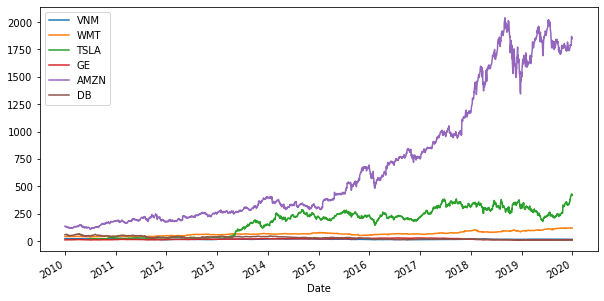

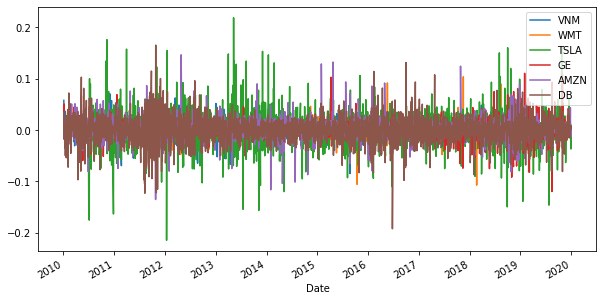

VNM    -0.027347
WMT     0.105408
TSLA    0.301474
GE      0.005754
AMZN    0.262423
DB     -0.199760
dtype: float64
           VNM       WMT      TSLA        GE      AMZN        DB
VNM   0.060648  0.008911  0.026012  0.020382  0.022326  0.036512
WMT   0.008911  0.029746  0.011564  0.010982  0.010917  0.016709
TSLA  0.026012  0.011564  0.262101  0.028383  0.045129  0.045099
GE    0.020382  0.010982  0.028383  0.069775  0.024310  0.047176
AMZN  0.022326  0.010917  0.045129  0.024310  0.095270  0.039268
DB    0.036512  0.016709  0.045099  0.047176  0.039268  0.158839


In [15]:
data = download_data(stocks)
show_data(data)
returns = calculate_returns(data)
plot_daily_returns(returns)
show_statistics(returns)
weights=initialize_weights()

In [ ]:
data = download_data(stocks)
show_data(data)
returns = calculate_returns(data)
plot_daily_returns(returns)
show_statistics(returns)
weights=initialize_weights()
calculate_portfolio_return(returns,weights)
calculate_portfolio_variance(returns,weights)
preturns,pvariances=generate_portfolios(weights, returns)
plot_portfolios(preturns,pvariances)
optimum=optimize_portfolio(weights,returns)
print_optimal_portfolio(optimum, returns)
show_optimal_portfolio(optimum, returns, preturns, pvariances)